# Training Sienna image - Textual-inversion fine-tuning for Stable Diffusion using d🧨ffusers

This notebook shows how to "teach" Stable Diffusion a new concept via textual-inversion using 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers).


_By using just 3-5 images you can teach new concepts to Stable Diffusion and personalize the model on your own images_

For a general introduction to the Stable Diffusion model please refer to this [colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).

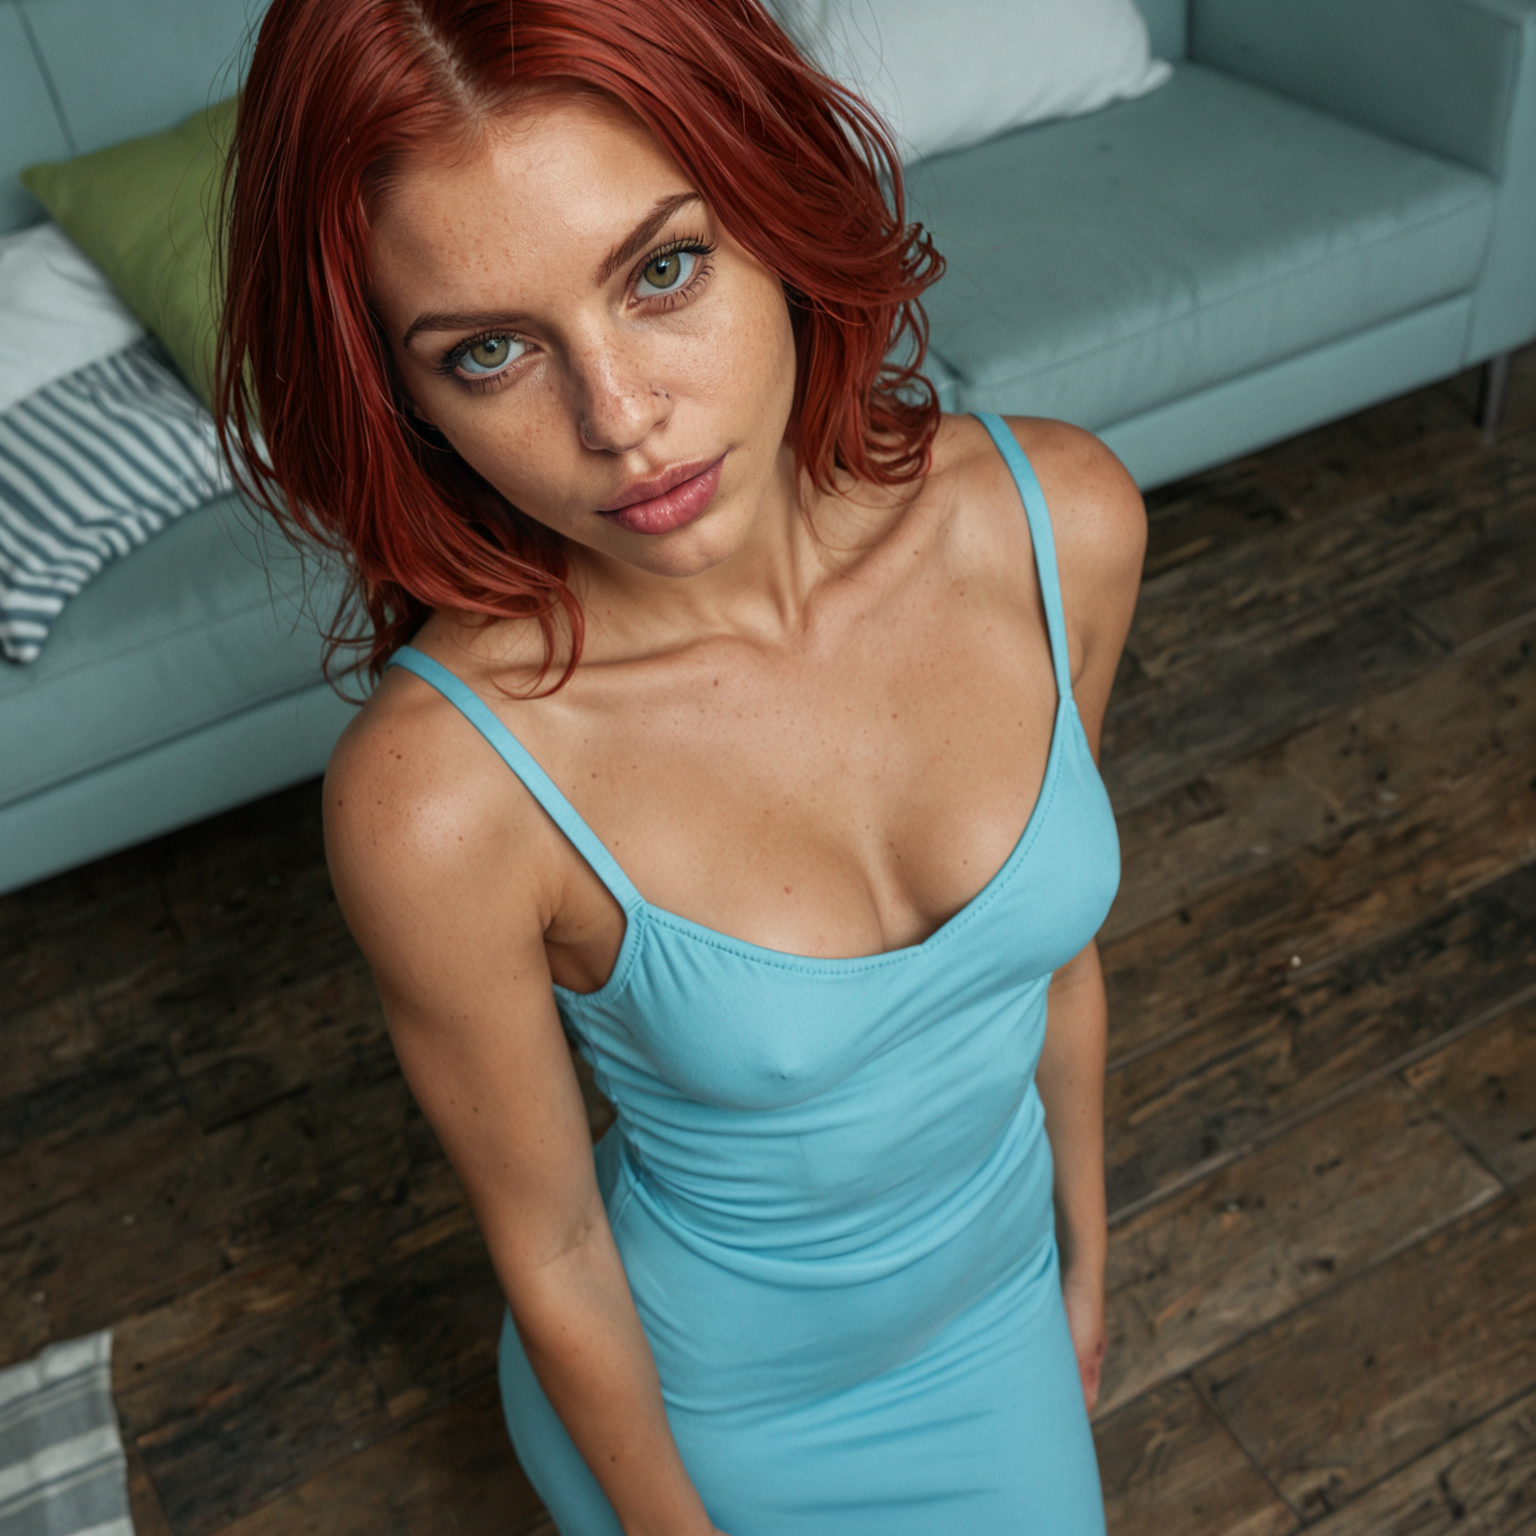

## Initial setup

In [23]:
#@title Install the required libs
!pip install -U -qq git+https://github.com/huggingface/diffusers.git
!pip install -qq accelerate transformers ftfy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 10.2 MB/s eta 0:00:00


In [9]:
#@title [Optional] Install xformers for faster and memory efficient training
#@markdown Acknowledgement: The xformers wheel are taken from [TheLastBen/fast-stable-diffusion](https://github.com/TheLastBen/fast-stable-diffusion). Thanks a lot for building these wheels!
%%time

!pip install -U --pre triton

from subprocess import getoutput
from IPython.display import HTML
from IPython.display import clear_output
import time

s = getoutput('nvidia-smi')
if 'T4' in s:
  gpu = 'T4'
elif 'P100' in s:
  gpu = 'P100'
elif 'V100' in s:
  gpu = 'V100'
elif 'A100' in s:
  gpu = 'A100'

while True:
    try:
        gpu=='T4'or gpu=='P100'or gpu=='V100'or gpu=='A100'
        break
    except:
        pass
    print('[1;31mit seems that your GPU is not supported at the moment')
    time.sleep(5)

if (gpu=='T4'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='P100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/P100/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='V100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/V100/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='A100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/A100/xformers-0.0.13.dev0-py3-none-any.whl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.2/253.2 MB 7.9 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.1.0
    Uninstalling triton-3.1.0:
      Successfully uninstalled triton-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires triton==3.1.0; platform_system == "Linux" and platform_machine == "x86_64" and python_version < "3.13", but you have triton 3.2.0 which is incompatible.


  ERROR: HTTP error 404 while getting https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/A100/xformers-0.0.13.dev0-py3-none-any.whl
ERROR: Could not install requirement xformers==0.0.13.dev0 from https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/A100/xformers-0.0.13.dev0-py3-none-any.whl because of HTTP error 404 Client Error: Not Found for url: https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/A100/xformers-0.0.13.dev0-py3-none-any.whl for URL https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/A100/xformers-0.0.13.dev0-py3-none-any.whl
CPU times: user 100 ms, sys: 15.7 ms, total: 116 ms
Wall time: 17.3 s


In [24]:
#@title [Optional] Login to the Hugging Face Hub
#@markdown Add a token with the "Write Access" role to be able to add your trained concept to the [Library of Concepts](https://huggingface.co/sd-concepts-library)
from huggingface_hub import notebook_login

notebook_login()

In [25]:
#@title Import required libraries
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Settings for teaching your new concept

In [26]:
#@markdown `pretrained_model_name_or_path` which Stable Diffusion checkpoint you want to use
pretrained_model_name_or_path = "stabilityai/stable-diffusion-2" #@param ["stabilityai/stable-diffusion-2", "stabilityai/stable-diffusion-2-base", "CompVis/stable-diffusion-v1-4", "runwayml/stable-diffusion-v1-5"] {allow-input: true}

### Get the training images:

#### Download the images from the internet and save them locally.

You can also upload the images to colab or load from google drive, please check the next section if you want to use that.

In [27]:
#@markdown Add here the URLs to the images of the concept you are adding. 3-5 should be fine
urls = [
      "https://huggingface.co/datasets/valhalla/images/resolve/main/2.jpeg",
      "https://huggingface.co/datasets/valhalla/images/resolve/main/3.jpeg",
      "https://huggingface.co/datasets/valhalla/images/resolve/main/5.jpeg",
      "https://huggingface.co/datasets/valhalla/images/resolve/main/6.jpeg",
      ## You can add additional images here
]

In [28]:
#@title Download
import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

images = list(filter(None,[download_image(url) for url in urls]))
save_path = "./my_concept"
if not os.path.exists(save_path):
  os.mkdir(save_path)
[image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]

[None, None, None, None]

#### Load images from local folder or google drive

You can also load your own training images from google drive or upload them to colab usingthe files taband then provide the path to the directory containing images.

*Make sure that the directory only contains images as the following cells will read all the files from the provided directory.*

In [29]:
from google.colab import drive
drive.mount('/content/gdrive')

MessageError: Error: credential propagation was unsuccessful

In [18]:
#@markdown `images_path` is a path to directory containing the training images. It could
images_path = "/content/" #@param {type:"string"}
while not os.path.exists(str(images_path)):
  print('The images_path specified does not exist, use the colab file explorer to copy the path :')
  images_path=input("")
save_path = images_path

####  Setup and check the images you have just added

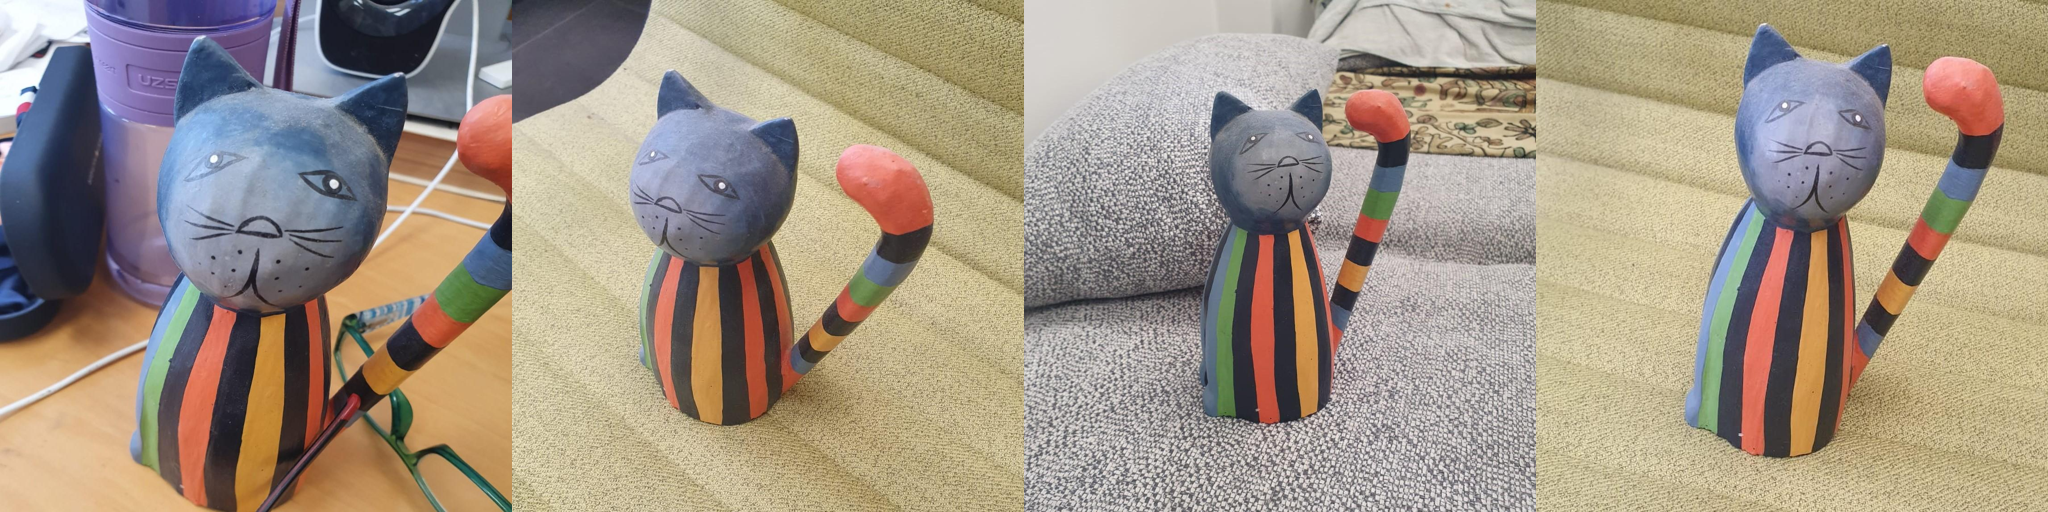

In [30]:
images = []
for file_path in os.listdir(save_path):
  try:
      image_path = os.path.join(save_path, file_path)
      images.append(Image.open(image_path).resize((512, 512)))
  except:
    print(f"{image_path} is not a valid image, please make sure to remove this file from the directory otherwise the training could fail.")
image_grid(images, 1, len(images))

In [22]:
#@title Settings for your newly created concept
#@markdown `what_to_teach`: what is it that you are teaching? `object` enables you to teach the model a new object to be used, `style` allows you to teach the model a new style one can use.
what_to_teach = "object" #@param ["object", "style"]
#@markdown `placeholder_token` is the token you are going to use to represent your new concept (so when you prompt the model, you will say "A `<my-placeholder-token>` in an amusement park"). We use angle brackets to differentiate a token from other words/tokens, to avoid collision.
placeholder_token = "sks" #@param {type:"string"}
#@markdown `initializer_token` is a word that can summarise what your new concept is, to be used as a starting point
initializer_token = "woman" #@param {type:"string"}

## Teach the model a new concept (fine-tuning with textual inversion)
Execute this this sequence of cells to run the training process. The whole process may take from 1-4 hours. (Open this block if you are interested in how this process works under the hood or if you want to change advanced training settings or hyperparameters)

### Create Dataset

In [31]:
#@title Setup the prompt templates for training
imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]

In [32]:
#@title Setup the dataset
class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="object",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):

        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL.Image.LINEAR,
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

### Setting up the model

In [33]:
# Model yolunu tanımla
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"

# Tokenizer kullanımı
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

#@title Load the tokenizer and add the placeholder token as a additional special token.
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder_token)
if num_added_tokens == 0:
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

In [34]:
#@title Get token ids for our placeholder and initializer token. This code block will complain if initializer string is not a single token
# Convert the initializer_token, placeholder_token to ids
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

In [35]:
#@title Load the Stable Diffusion model
# Load models and create wrapper for stable diffusion
# pipeline = StableDiffusionPipeline.from_pretrained(pretrained_model_name_or_path)
# del pipeline
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)

We have added the `placeholder_token` in the `tokenizer` so we resize the token embeddings here, this will a new embedding vector in the token embeddings for our `placeholder_token`

In [36]:
text_encoder.resize_token_embeddings(len(tokenizer))

Embedding(49409, 768)

 Initialise the newly added placeholder token with the embeddings of the initializer token

In [37]:
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

In Textual-Inversion we only train the newly added embedding vector, so lets freeze rest of the model parameters here

In [38]:
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae and unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

### Creating our training data

Let's create the Dataset and Dataloader

In [39]:
import os
import PIL
import torch
import numpy as np
import random
from torch.utils.data import Dataset

class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="object",
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):
        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)
                         if file_path.lower().endswith(('.png', '.jpg', '.jpeg'))]

        self.num_images = len(self.image_paths)
        self._length = self.num_images
        print(f"Found {self.num_images} images in {self.data_root}")

        if set == "train":
            self._length = self.num_images * repeats

        # PIL.Image.LINEAR hatası için düzeltilmiş kod
        self.interpolation = {
            "linear": PIL.Image.BILINEAR,  # LINEAR yerine BILINEAR kullanıyoruz
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
        }.get(interpolation, PIL.Image.BILINEAR)

        self.templates = [
            "a photo of a {}",
            "a rendering of a {}",
            "a cropped photo of the {}",
            "the photo of a {}",
            "a photo of a clean {}",
            "a photo of a dirty {}",
            "a dark photo of the {}",
            "a photo of my {}",
            "a photo of the cool {}",
            "a close-up photo of a {}",
            "a bright photo of the {}",
            "a cropped photo of a {}",
            "a photo of the {}",
            "a good photo of the {}",
            "a photo of one {}",
            "a close-up photo of the {}",
            "a rendition of the {}",
            "a photo of the clean {}",
            "a rendition of a {}",
            "a photo of a nice {}",
            "a good photo of a {}",
            "a photo of the nice {}",
            "a photo of the small {}",
            "a photo of the weird {}",
            "a photo of the large {}",
            "a photo of a cool {}",
            "a photo of a small {}",
        ]

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = PIL.Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)
        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # Preprocessing for images
        if self.center_crop:
            crop = min(image.size)
            image = image.crop(
                ((image.size[0] - crop) // 2,
                 (image.size[1] - crop) // 2,
                 (image.size[0] + crop) // 2,
                 (image.size[1] + crop) // 2)
            )

        image = image.resize((self.size, self.size), resample=self.interpolation)

        if random.random() < self.flip_p:
            image = image.transpose(PIL.Image.FLIP_LEFT_RIGHT)

        image = np.array(image).astype(np.float32) / 127.5 - 1.0
        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)

        return example

211 resim bulundu.
Found 211 images in /content/sienna_dataset
Dataset oluşturuldu! 21100 örnek.


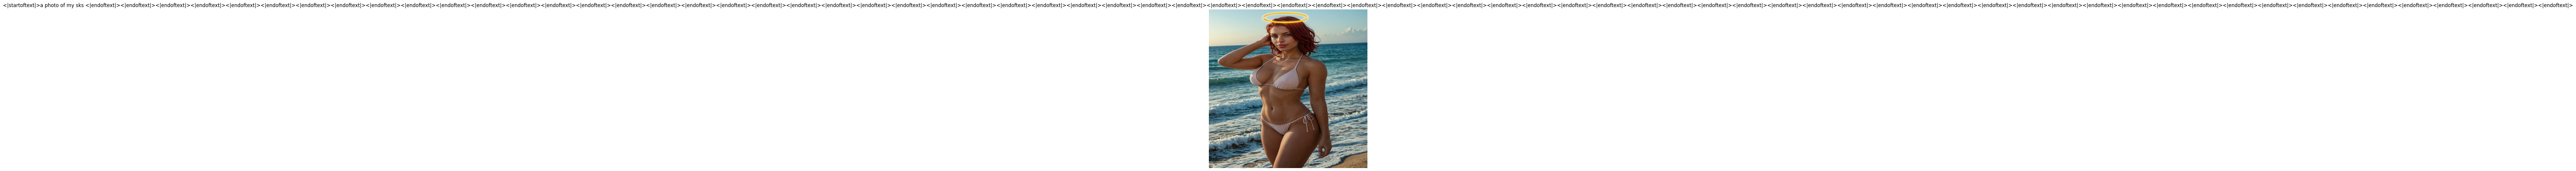

In [40]:
# Dataset oluşturma kodu (bu kodu TextualInversionDataset sınıfından SONRA çalıştırın)

# Resim klasörünü tanımla
save_path = "/content/sienna_dataset"  # Resimlerinizin olduğu klasör yolu
os.makedirs(save_path, exist_ok=True)

# Resim kontrolü
image_files = [f for f in os.listdir(save_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if len(image_files) == 0:
    print(f"UYARI: {save_path} klasöründe resim bulunamadı!")

    # Google Colab'deyseniz resim yükleme için kod
    from google.colab import files
    print("Resim yüklemek için:")
    uploaded = files.upload()

    # Yüklenen resimleri dataset klasörüne taşı
    for filename in uploaded.keys():
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            with open(os.path.join(save_path, filename), 'wb') as f:
                f.write(uploaded[filename])
            print(f"{filename} dosyası {save_path} klasörüne kaydedildi.")
else:
    print(f"{len(image_files)} resim bulundu.")

# Dataset'i oluştur
train_dataset = TextualInversionDataset(
    data_root=save_path,
    tokenizer=tokenizer,
    size=512,
    placeholder_token=placeholder_token,
    repeats=100,
    learnable_property=what_to_teach,  # Bu değişken tanımlanmış olmalı
    center_crop=False,
    set="train",
)

print(f"Dataset oluşturuldu! {len(train_dataset)} örnek.")

# Önizleme (isteğe bağlı)
try:
    import matplotlib.pyplot as plt
    sample = train_dataset[0]
    img = sample["pixel_values"].permute(1, 2, 0)
    img = (img + 1.0) * 127.5
    img = img.numpy().astype(np.uint8)

    plt.figure(figsize=(7, 7))
    plt.imshow(img)
    plt.title(tokenizer.decode(sample["input_ids"]))
    plt.axis("off")
    plt.show()
except Exception as e:
    print(f"Önizleme gösterilemiyor: {e}")

In [41]:
# Dataset'i oluştur (BU KODU AYRI BİR HÜCREDE ÇALIŞTIRIN)
train_dataset = TextualInversionDataset(
    data_root=save_path,
    tokenizer=tokenizer,
    size=512,
    placeholder_token=placeholder_token,
    repeats=100,
    learnable_property=what_to_teach,
    center_crop=False,
    set="train",
)

Found 211 images in /content/sienna_dataset


In [42]:
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

Create noise_scheduler for training

In [43]:
noise_scheduler = DDPMScheduler.from_config(pretrained_model_name_or_path, subfolder="scheduler")

/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [44]:
# sks.pt dosyasını yükle
from google.colab import files

print("Lütfen sks.pt dosyasını yükleyin:")
uploaded = files.upload()

# Yüklenen dosyanın yolunu al
for filename in uploaded.keys():
    if filename.endswith('.pt'):
        pt_path = filename
        print(f"Yüklenen dosya: {pt_path}")
        break

Lütfen sks.pt dosyasını yükleyin:


### Training

Define hyperparameters for our training
If you are not happy with your results, you can tune the `learning_rate` and the `max_train_steps`

In [45]:
#@title Setting up all training args
hyperparameters = {
    "learning_rate": 5e-04,
    "scale_lr": True,
    "max_train_steps": 2000,
    "save_steps": 250,
    "train_batch_size": 4,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": True,
    "mixed_precision": "fp16",
    "seed": 42,
    "output_dir": "sd-concept-output"
}
!mkdir -p sd-concept-output

Train!

In [46]:
# Eksik itertools modülünü import et
import itertools
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel

# Pretrained model path
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"

# Değişkenleri tanımla (eğer tanımlanmamışsa)
if 'text_encoder' not in globals():
    print("Model bileşenlerini yükleme...")

    # Tokenizer
    if 'tokenizer' not in globals():
        tokenizer = CLIPTokenizer.from_pretrained(
            pretrained_model_name_or_path,
            subfolder="tokenizer"
        )
        print("Tokenizer yüklendi.")

    # Text Encoder
    text_encoder = CLIPTextModel.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder"
    )
    print("Text encoder yüklendi.")

    # VAE
    vae = AutoencoderKL.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="vae"
    )
    print("VAE yüklendi.")

    # UNet
    unet = UNet2DConditionModel.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="unet"
    )
    print("UNet yüklendi.")

    # Placeholder token yükleme (eğer daha önce tanımlanmadıysa)
    if 'placeholder_token' not in globals():
        placeholder_token = "sks"
        print(f"Placeholder token: {placeholder_token}")

    # Placeholder token ID kontrolü
    if 'placeholder_token_id' not in globals():
        # Tokenizer'a placeholder token'ı ekle
        num_added_tokens = tokenizer.add_tokens(placeholder_token)
        placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

        # Text encoder'ın token embedding tablosunu genişlet
        text_encoder.resize_token_embeddings(len(tokenizer))

        # Placeholder token'ı bir şeyden başlat (örn. "woman")
        if 'initializer_token' not in globals():
            initializer_token = "woman"

        initializer_token_id = tokenizer.convert_tokens_to_ids(initializer_token)

        # Başlangıç değerine göre initialize et
        token_embeds = text_encoder.get_input_embeddings().weight.data
        token_embeds[placeholder_token_id] = token_embeds[initializer_token_id].clone()

        print(f"Placeholder token ID: {placeholder_token_id}")
        print(f"Initializer token: {initializer_token}")

    # Dataset kontrolü
    if 'train_dataset' not in globals():
        print("UYARI: train_dataset tanımlanmamış! Eğitim çalışmayacak.")
        print("Lütfen önce TextualInversionDataset sınıfını tanımlayın ve bir dataset oluşturun.")

In [47]:
# Gelişmiş eğitim ayarları
training_args = {
    "max_train_steps": 20000,            # Daha uzun eğitim (önceki 5000'den çok daha fazla)
    "learning_rate": 1e-5,               # Daha düşük öğrenme oranı (daha stabil sonuçlar için)
    "train_batch_size": 2,               # Yüksek GPU ile batch size artırabilirsiniz
    "gradient_accumulation_steps": 4,    # Etkili batch size'ı 8'e çıkarır
    "resolution": 768,                   # Daha yüksek çözünürlük
    "scale_lr": True,                    # Batch size artışına göre learning rate ayarı
    "lr_scheduler": "constant_with_warmup", # Warmup ile başlangıç
    "lr_warmup_steps": 500,              # İlk 500 adımda öğrenme oranı yavaşça artar
    "adam_beta1": 0.9,                   # Adam optimizer parametreleri
    "adam_beta2": 0.999,
    "adam_weight_decay": 1e-2,           # Regularization için
    "adam_epsilon": 1e-08,
    "mixed_precision": "fp16",           # Hızlı eğitim için
    "seed": 42                           # Tekrarlanabilirlik için sabit seed
}

In [48]:
# Gerekli kütüphaneleri import et
import os
import math
import logging
import torch
import torch.nn.functional as F
from accelerate import Accelerator
from tqdm.auto import tqdm
from diffusers import DDPMScheduler, StableDiffusionPipeline

# Logger fonksiyonu tanımla
def get_logger(name=__name__):
    logger = logging.getLogger(name)
    handler = logging.StreamHandler()
    formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)
    return logger

# Eksik hyperparameters değişkenini tanımla
hyperparameters = {
    "train_batch_size": 1,
    "gradient_accumulation_steps": 4,
    "learning_rate": 1e-4,
    "max_train_steps": 5000,
    "output_dir": "/content/textual_inversion_model",
    "gradient_checkpointing": False,
    "mixed_precision": "fp16" if torch.cuda.is_available() else "no",
    "scale_lr": True,
    "save_steps": 500
}

# Eksik create_dataloader fonksiyonu
def create_dataloader(batch_size):
    return torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

# Klasör oluştur
os.makedirs(hyperparameters["output_dir"], exist_ok=True)

# Eksik noise_scheduler değişkeni (eğer tanımlanmamışsa)
if 'noise_scheduler' not in globals():
    try:
        noise_scheduler = DDPMScheduler.from_pretrained(
            pretrained_model_name_or_path, subfolder="scheduler"
        )
    except NameError:
        print("pretrained_model_name_or_path tanımlanmamış!")

In [49]:
#@title Training function
logger = get_logger(__name__)

def save_progress(text_encoder, placeholder_token_id, accelerator, save_path):
    logger.info("Saving embeddings")
    learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
    learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
    torch.save(learned_embeds_dict, save_path)

def training_function(text_encoder, vae, unet):
    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]
    gradient_checkpointing = hyperparameters["gradient_checkpointing"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
        mixed_precision=hyperparameters["mixed_precision"]
    )

    if gradient_checkpointing:
        text_encoder.gradient_checkpointing_enable()
        unet.enable_gradient_checkpointing()

    train_dataloader = create_dataloader(train_batch_size)

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
        lr=learning_rate,
    )

    text_encoder, optimizer, train_dataloader = accelerator.prepare(
        text_encoder, optimizer, train_dataloader
    )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move vae and unet to device
    vae.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)

    # Keep vae in eval mode as we don't train it
    vae.eval()
    # Keep unet in train mode to enable gradient checkpointing
    unet.train()


    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample().detach()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states.to(weight_dtype)).sample

                 # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                loss = F.mse_loss(noise_pred, target, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
                # Get the index for tokens that we want to zero the grads for
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                if global_step % hyperparameters["save_steps"] == 0:
                    save_path = os.path.join(output_dir, f"learned_embeds-step-{global_step}.bin")
                    save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()


    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path,
            text_encoder=accelerator.unwrap_model(text_encoder),
            tokenizer=tokenizer,
            vae=vae,
            unet=unet,
        )
        pipeline.save_pretrained(output_dir)
        # Also save the newly trained embeddings
        save_path = os.path.join(output_dir, f"learned_embeds.bin")
        save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

In [ ]:
import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))

for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
  if param.grad is not None:
    del param.grad  # free some memory
  torch.cuda.empty_cache()

Launching training on one GPU.


2025-03-08 23:15:34,917 - __main__ - INFO - ***** Running training *****
2025-03-08 23:15:34,917 - __main__ - INFO - ***** Running training *****
2025-03-08 23:15:34,917 - __main__ - INFO - ***** Running training *****
INFO:__main__:***** Running training *****
2025-03-08 23:15:34,921 - __main__ - INFO -   Num examples = 21100
2025-03-08 23:15:34,921 - __main__ - INFO -   Num examples = 21100
2025-03-08 23:15:34,921 - __main__ - INFO -   Num examples = 21100
INFO:__main__:  Num examples = 21100
2025-03-08 23:15:34,924 - __main__ - INFO -   Instantaneous batch size per device = 1
2025-03-08 23:15:34,924 - __main__ - INFO -   Instantaneous batch size per device = 1
2025-03-08 23:15:34,924 - __main__ - INFO -   Instantaneous batch size per device = 1
INFO:__main__:  Instantaneous batch size per device = 1
2025-03-08 23:15:34,926 - __main__ - INFO -   Total train batch size (w. parallel, distributed & accumulation) = 4
2025-03-08 23:15:34,926 - __main__ - INFO -   Total train batch size (w

  0%|          | 0/5000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


In [3]:
# Sistemdeki tüm .pt ve .bin dosyalarını ara
!find /content -name "*.pt" -o -name "*.bin"

/content/sks.pt


In [4]:
# Özel klasörleri kontrol et
!ls -la /content/textual_inversion_model/ 2>/dev/null || echo "Bu klasör yok"
!ls -la /content/*learned_embeds* 2>/dev/null || echo "Bu şablonda dosya yok"

total 28
drwxr-xr-x 2 root root  4096 Mar  8 22:47 .
drwxr-xr-x 1 root root 20480 Mar  8 22:55 ..
Bu şablonda dosya yok


In [5]:
# Eğitim çıktı yollarını değişkenlerden kontrol et
# 'token_save_path' varsa yazdır
if 'token_save_path' in locals() or 'token_save_path' in globals():
    print(f"Token kayıt yolu: {token_save_path}")

# Benzeri değişkenleri kontrol et
for var_name in ['save_path', 'output_dir', 'model_save_dir', 'embedding_path']:
    if var_name in locals() or var_name in globals():
        print(f"{var_name}: {eval(var_name)}")

In [6]:
# Tüm global değişkenleri listele
import sys
path_vars = [var for var in dir() if isinstance(eval(var), str) and ('path' in var.lower() or 'dir' in var.lower() or 'save' in var.lower() or 'output' in var.lower())]
print("Olası dosya yolu içeren değişkenler:")
for var in path_vars:
    try:
        value = eval(var)
        if isinstance(value, str):
            print(f"{var} = {value}")
    except:
        pass

Olası dosya yolu içeren değişkenler:


In [7]:
# Eğitim sırasında oluşturulan embedding'i text_encoder'dan alma
import torch
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline

try:
    # Eğer text_encoder hala bellekte varsa ve eğitim yapıldıysa,
    # embedding'i doğrudan oradan alabiliriz
    if 'text_encoder' in globals() and 'placeholder_token_id' in globals():
        # Embedding'i al
        embedding_tensor = text_encoder.get_input_embeddings().weight[placeholder_token_id].detach().clone()

        # Geçici bir dosyaya kaydet
        embedding_dict = {placeholder_token: embedding_tensor}
        temp_file = f"/content/{placeholder_token}_embedding.pt"
        torch.save(embedding_dict, temp_file)

        print(f"Embedding geçici olarak kaydedildi: {temp_file}")

        # Stable Diffusion ile test et
        model_id = "runwayml/stable-diffusion-v1-5"
        pipe = StableDiffusionPipeline.from_pretrained(model_id)

        # Embedding'i yükle
        pipe.load_textual_inversion(temp_file)

        # Test prompt
        prompt = f"a photo of {placeholder_token} woman in paris"

        # Görüntü oluştur
        image = pipe(prompt, num_inference_steps=30).images[0]

        # Görüntüyü göster
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.title(prompt)
        plt.axis("off")
        plt.show()

        # Oluşturulan dosyayı indirme seçeneği
        from google.colab import files
        files.download(temp_file)
    else:
        print("Eğitilmiş text_encoder bulunamadı veya bellekte değil.")
except Exception as e:
    print(f"Hata oluştu: {e}")

Eğitilmiş text_encoder bulunamadı veya bellekte değil.


## Run the code with your newly trained model
If you have just trained your model with the code above, use the block below to run it

To save this concept for re-using, download the `learned_embeds.bin` file or save it on the library of concepts.

Use the [Stable Conceptualizer notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_conceptualizer_inference.ipynb) for inference with persistently saved pre-trained concepts

In [ ]:
#@title Save your newly created concept to the [library of concepts](https://huggingface.co/sd-concepts-library)?

save_concept_to_public_library = True #@param {type:"boolean"}
name_of_your_concept = "Sienna" #@param {type:"string"}
#@markdown `hf_token_write`: leave blank if you logged in with a token with `write access` in the [Initial Setup](#scrollTo=KbzZ9xe6dWwf). If not, [go to your tokens settings and create a write access token](https://huggingface.co/settings/tokens)
hf_token_write = "" #@param {type:"string"}

if(save_concept_to_public_library):
  from slugify import slugify
  from huggingface_hub import HfApi, HfFolder, CommitOperationAdd
  from huggingface_hub import create_repo
  repo_id = f"sd-concepts-library/{slugify(name_of_your_concept)}"
  output_dir = hyperparameters["output_dir"]
  if(not hf_token_write):
    with open(HfFolder.path_token, 'r') as fin: hf_token = fin.read();
  else:
    hf_token = hf_token_write
  #Join the Concepts Library organization if you aren't part of it already
  !curl -X POST -H 'Authorization: Bearer '$hf_token -H 'Content-Type: application/json' https://huggingface.co/organizations/sd-concepts-library/share/VcLXJtzwwxnHYCkNMLpSJCdnNFZHQwWywv
  images_upload = os.listdir("my_concept")
  image_string = ""
  repo_id = f"sd-concepts-library/{slugify(name_of_your_concept)}"
  for i, image in enumerate(images_upload):
      image_string = f'''{image_string}![{placeholder_token} {i}](https://huggingface.co/{repo_id}/resolve/main/concept_images/{image})
'''
  if(what_to_teach == "style"):
      what_to_teach_article = f"a `{what_to_teach}`"
  else:
      what_to_teach_article = f"an `{what_to_teach}`"
  readme_text = f'''---
license: mit
base_model: {pretrained_model_name_or_path}
---
### {name_of_your_concept} on Stable Diffusion
This is the `{placeholder_token}` concept taught to Stable Diffusion via Textual Inversion. You can load this concept into the [Stable Conceptualizer](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_conceptualizer_inference.ipynb) notebook. You can also train your own concepts and load them into the concept libraries using [this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb).

Here is the new concept you will be able to use as {what_to_teach_article}:
{image_string}
'''
  #Save the readme to a file
  readme_file = open("README.md", "w")
  readme_file.write(readme_text)
  readme_file.close()
  #Save the token identifier to a file
  text_file = open("token_identifier.txt", "w")
  text_file.write(placeholder_token)
  text_file.close()
  #Save the type of teached thing to a file
  type_file = open("type_of_concept.txt","w")
  type_file.write(what_to_teach)
  type_file.close()
  operations = [
    CommitOperationAdd(path_in_repo="learned_embeds.bin", path_or_fileobj=f"{output_dir}/learned_embeds.bin"),
    CommitOperationAdd(path_in_repo="token_identifier.txt", path_or_fileobj="token_identifier.txt"),
    CommitOperationAdd(path_in_repo="type_of_concept.txt", path_or_fileobj="type_of_concept.txt"),
    CommitOperationAdd(path_in_repo="README.md", path_or_fileobj="README.md"),
  ]
  create_repo(repo_id,private=True, token=hf_token)
  api = HfApi()
  api.create_commit(
    repo_id=repo_id,
    operations=operations,
    commit_message=f"Upload the concept {name_of_your_concept} embeds and token",
    token=hf_token
  )
  api.upload_folder(
    folder_path=save_path,
    path_in_repo="concept_images",
    repo_id=repo_id,
    token=hf_token
  )

In [ ]:
#@title Set up the pipeline
from diffusers import DPMSolverMultistepScheduler
pipe = StableDiffusionPipeline.from_pretrained(
    hyperparameters["output_dir"],
    scheduler=DPMSolverMultistepScheduler.from_pretrained(hyperparameters["output_dir"], subfolder="scheduler"),
    torch_dtype=torch.float16,
).to("cuda")

In [ ]:
#@title Run the Stable Diffusion pipeline
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "a portrait of sks woman in an elegant dress, professional photography, studio lighting, high detail" #@param {type:"string"}

num_samples = 2 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = []
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, num_inference_steps=30, guidance_scale=7.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid

In [8]:
# GitHub repo'ya yerel dosyaları aktarma
import os
import subprocess

# Cursor'daki proje konumu
cursor_dir = "/Users/sarperhorata/insta-hashtag-creator/Sienna Carter"

# GitHub işlemleri
github_commands = [
    f"cd '{cursor_dir}' && git init",
    f"cd '{cursor_dir}' && git add .",
    f"cd '{cursor_dir}' && git commit -m 'Add Sienna project files from Cursor'",
    f"cd '{cursor_dir}' && git remote add origin https://github.com/sarperhorata/sienna.git",
    f"cd '{cursor_dir}' && git push -u origin main --force"
]

print("GitHub senkronizasyon komutları (terminalde çalıştırın):")
for cmd in github_commands:
    print(cmd)

GitHub senkronizasyon komutları (terminalde çalıştırın):
cd '/Users/sarperhorata/insta-hashtag-creator/Sienna Carter' && git init
cd '/Users/sarperhorata/insta-hashtag-creator/Sienna Carter' && git add .
cd '/Users/sarperhorata/insta-hashtag-creator/Sienna Carter' && git commit -m 'Add Sienna project files from Cursor'
cd '/Users/sarperhorata/insta-hashtag-creator/Sienna Carter' && git remote add origin https://github.com/sarperhorata/sienna.git
cd '/Users/sarperhorata/insta-hashtag-creator/Sienna Carter' && git push -u origin main --force
